# Lesson 4:detailed steps for detecting disturbance studies using HLS datasets
This tutorial will guide you through processing HLS imagery data using pyxccd to generate annual disturbance maps, recent disturbance maps, and first disturbance maps. The workflow consists of three main steps.

## Preparation

### 1. Install Pyxccd
```
pip install pyxccd
```

### 2. Prepare HLS images
Prepare downloaded HLS files with the following structure (example contains 6 years of HLS data from 2019-2024):  
Quark Drive download link: https://pan.quark.cn/s/f6456bf1ad27?pwd=FxtU  
Extraction code: FxtU
```
HLS_root_directory/
└── Tile_ID (e.g., 51RTP)/
    └── HLS_daily_folder (e.g., HLS.S30.T51RTP.2021238T023551.v2.0)
        └── HLS_image_files (e.g., HLS.L30.T51RTP.2021238T023146.v2.0.B02.tif)
```

### 3. Configuration File
Prepare `config_hls.yaml` with adjustable block size parameters (example uses 30×30 blocks):
```yaml
DATASETINFO:
  n_rows: 3660
  n_cols: 3660
  n_block_x: 30
  n_block_y: 30
```

## Step 1: Image Stack Processing

### Purpose
Stack HLS images in time series for subsequent change detection.

### Procedure
1. Adjust the configuration in config.yaml as needed

2. CD to the folder `pyxccd\tutorials\notebooks` and run stacking script:
```bash
python prepare_ard.py --source_path /path/to/HLS_root_directory/Tile_ID \
                     --yaml_path /path/to/config.yaml \
                     --out_path /path/to/stack/data \
                     --low_date_bound 2019-01-01 \
                     --upp_date_bound 2024-12-31 \
                     --n_cores 16
```

### Parameters
```
--source_path: HLS data directory (HLS/51RTP)
--yaml_path: Configuration file path
--out_path: Output directory for stacked data
--low_date_bound: Start date (YYYY-MM-DD)
--upp_date_bound: End date (YYYY-MM-DD)
--n_cores: The total cores assigned
```

### Output
The output directory (`stack` by default) will contain `{TileID}_stack` folders with block-organized stacked data for each tile.

## Step 2: Change Detection (SCCD & COLD)

### SCCD Algorithm
#### Purpose
Detect pixel-level changes using pyxccd's SCCD algorithm.

#### Procedure
1. Complete the stacking process (Step 1)
2. Run SCCD detection script:
```bash
python tile_processing.py --method SCCDOFFLINE \
                     --stack_path /path/to/stack/data \
                     --yaml_path /path/to/config.yaml \
                     --result_path /path/to/sccd_results \
                     --low_datebound 2019-01-01 \
                     --upper_datebound 2024-12-31 \
                     --n_cores 16
```

#### Parameters
```
--stack_path: Stacked data directory from Step 1
--result_path: Output directory for SCCD results
(Other parameters same as Step 1)
```

#### Output
The output directory (`sccd_results` by default) will contain:
```
record_change_x{blockX}_y{blockY}_sccd.npy: Change detection results per block
SCCD_block{blockID}_finished.txt: Completion marker files
```

### COLD Algorithm
#### Purpose
Detect pixel-level changes using pyxccd's COLD algorithm.

#### Procedure
1. Complete the stacking process (Step 1)
2. Run COLD detection script:
```bash
python tile_processing.py --method COLD \
                     --stack_path /path/to/stack/data \
                     --yaml_path /path/to/config.yaml \
                     --result_path /path/to/cold_results \
                     --low_datebound 2019-01-01 \
                     --upper_datebound 2024-12-31 \
                     --n_cores 16
```
 or S-CCD
 ```bash
python tile_processing.py --method SCCDOFFLINE \
                     --stack_path /path/to/stack/data \
                     --yaml_path /path/to/config.yaml \
                     --result_path /path/to/cold_results \
                     --low_datebound 2019-01-01 \
                     --upper_datebound 2024-12-31 \
                     --n_cores 16
```

#### Parameters
```
--stack_path: Stacked data directory from Step 1
--result_parent_path: Output directory for COLD results
(Other parameters same as Step 1)
```

#### Output
The output directory (`cold_results` by default) will contain:
```
record_change_x{blockX}_y{blockY}_cold.npy: Change detection results per block
COLD_block{blockID}_finished.txt: Completion marker files
```

## Step 3: Disturbance Map Generation

### Purpose
Convert change detection results into annual/recent/first disturbance maps.

### Procedure
1. Complete Steps 1-2
2. Run disturbance mapping script:
```bash

COLD:
python export_change_map.py --source_dir /path/to/HLS_root_directory/Tile_ID \
                               --result_path /path/to/cold_results \
                               --out_path /path/to/disturbance_maps \
                               --method COLD \
                               --yaml_path /path/to/config.yaml \
                               --year_lowbound 2019 \
                               --year_uppbound 2024 \
                               --n_cores 16
```
S-CCD:
```bash
python export_change_map.py --source_dir /path/to/HLS_root_directory/Tile_ID \
                               --result_path /path/to/sccd_results \
                               --out_path /path/to/disturbance_maps \
                               --method SCCDOFFLINE \
                               --yaml_path /path/to/config.yaml \
                               --year_lowbound 2019 \
                               --year_uppbound 2024 \
                               --n_cores 16
```

### Parameters
```
--source_dir: HLS directory (for spatial reference)
--result_path: SCCD or COLD results directory 
--out_path: Output directory for disturbance maps
--method: SCCDOFFLINE or COLD
--year_lowbound: Start year
--year_uppbound: End year
--n_cores: The total cores assigned
```

### Output
The output directory (`disturbance_maps` by default) will contain:
```
For SCCDOFFLINE method:
{year}_break_map_SCCDOFFLINE.tif: Annual disturbance map
first_disturbance_map_SCCDOFFLINE.tif: First disturbance map (year of first disturbance)
recent_disturbance_map_SCCDOFFLINE.tif: Recent disturbance map (year of latest disturbance)

For COLD method:
{year}_break_map_COLD.tif: Annual disturbance map
first_disturbance_map_COLD.tif: First disturbance map (year of first disturbance)
recent_disturbance_map_COLD.tif: Recent disturbance map (year of latest disturbance)
```

### Interpretation
#### Annual Disturbance Maps
Pixel value = disturbance_type × 1000 + day_of_year  
Disturbance types (COLD):  
&nbsp;&nbsp;1 - Disturbance  
&nbsp;&nbsp;2 - Regrowth
&nbsp;&nbsp;3 - Restoration

Disturbance types (S-CCD):  
&nbsp;&nbsp;1 - Disturbance  
&nbsp;&nbsp;2 - Recovery


#### Recent Disturbance Map
Shows the most recent disturbance year for each pixel  
0 indicates no disturbance

#### First Disturbance Map
Shows the first disturbance year for each pixel  
0 indicates no disturbance


## Important Notes
1. For large areas, process tiles in batches to avoid memory overload
2. Adjust block size parameters in config_hls.yaml to balance speed and memory usage
3. Interrupted processing can be resumed - the script will skip completed blocks


## Example Output
2019-2024 First Disturbance Map (COLD):

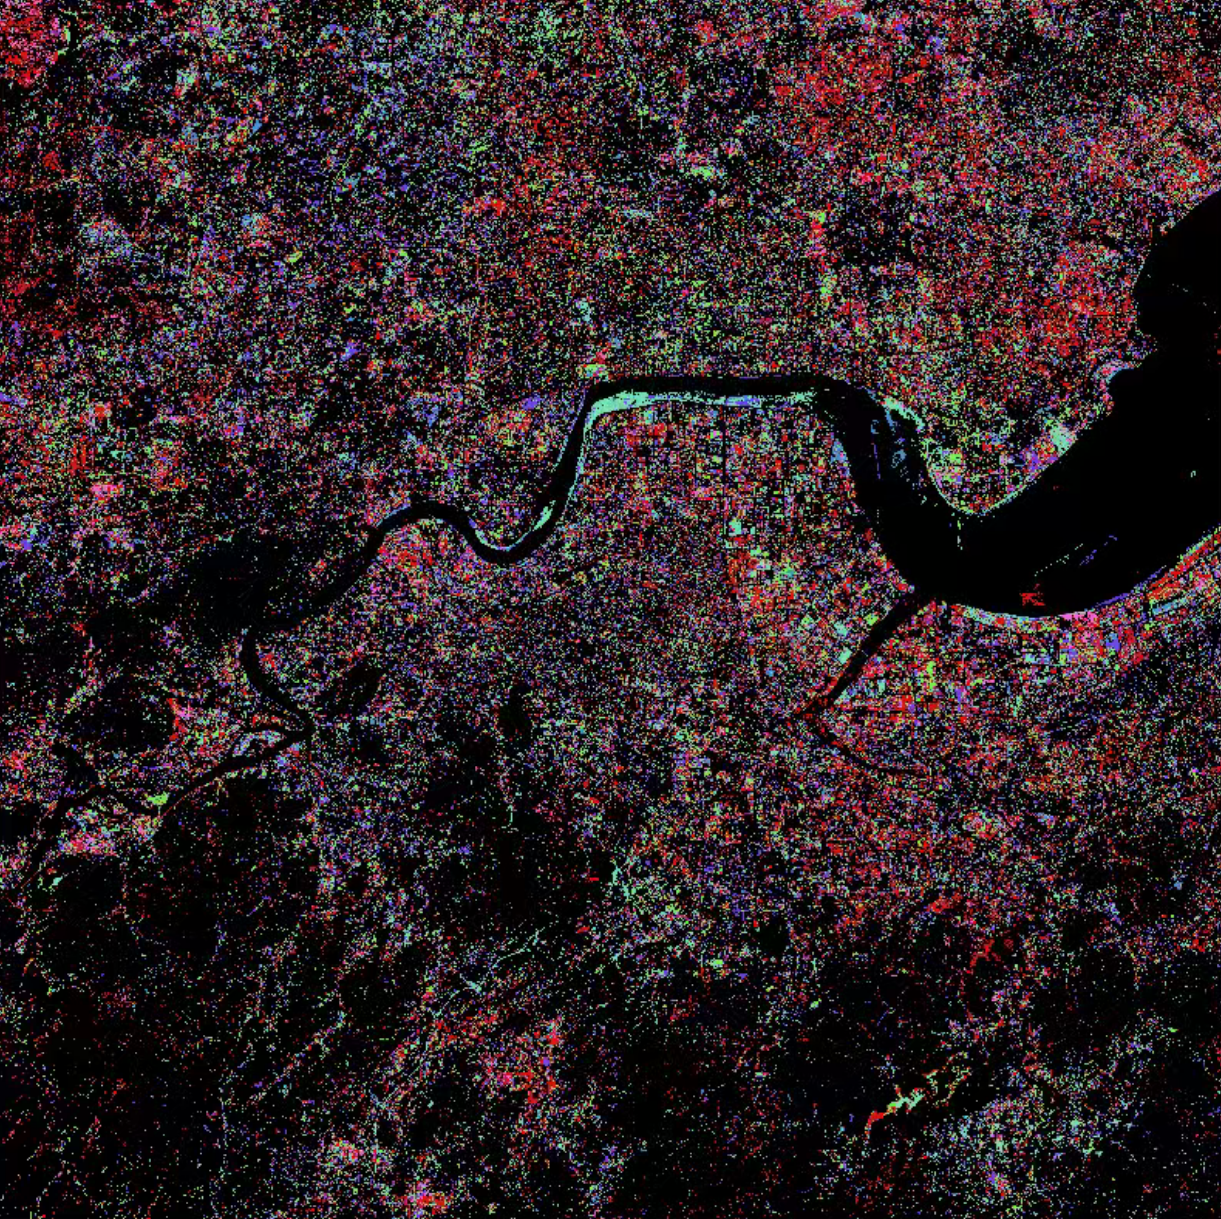

2019-2024 First Disturbance Map (SCCD):

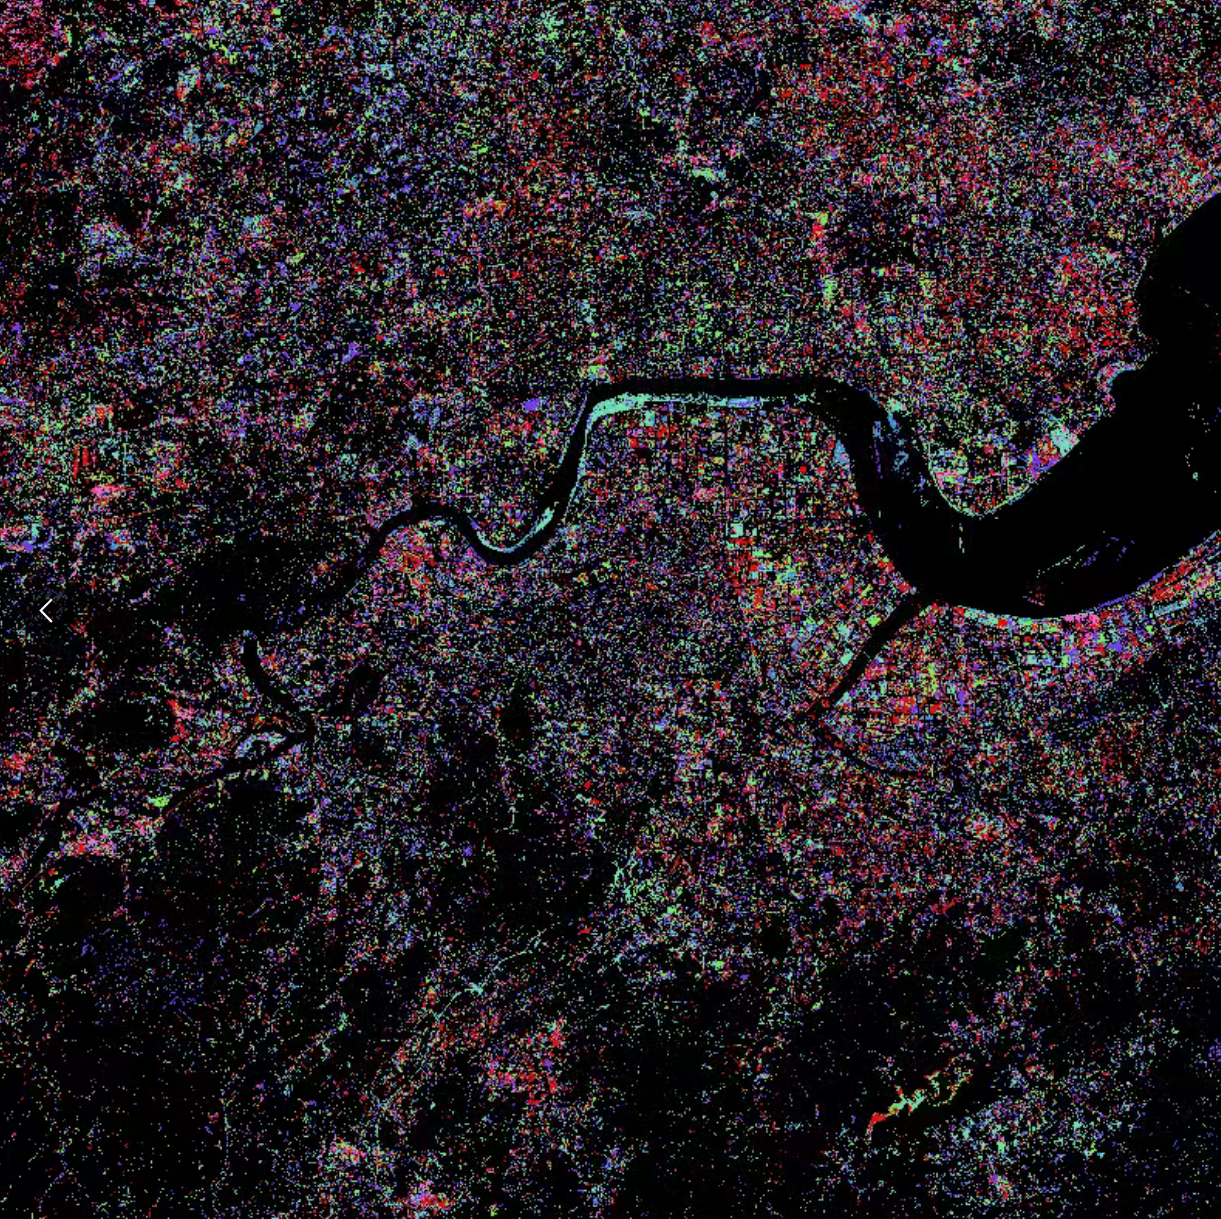
